**This notebook will become qmd in the future. For now, it is a jupyter notebook.**

ideas for introduction to AB slide or maybe earlier slides:
- talk about prior predictive check
- Beta prior <--> Binomial likelihood
    - we observe some people converted in A and B (likelihood)
    - We want to learn more about conversion probability theta.
    - Hence we need Beta prior for theta
- introduce HDI




In [1]:
from dataclasses import dataclass
from typing import Dict, List, Union

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.stats import bernoulli, expon

In [2]:
RANDOM_SEED = 4000
rng = np.random.default_rng(RANDOM_SEED)

plotting_defaults = dict(
    bins=50,
    kind="hist",
    textsize=8,
)

# Two Variants A, B
## Bernoulli conversion
### PART I: there's no data yet, let's check the prior

In [3]:
# let's define the variants A and B, and the number of trials and successes
variants  = ['A', 'B']

# each variant has one trail 
trials    = [1, 1]

# the only trial leads to success
successes = [1, 1]

# let's define parameters for a weak prior for the conversion rates
weak_alpha, weak_beta = [100, 100]

The model has four main components:
- Prior
- Likelihood
- Uplift (difference between A and B)
- Posterior (or just checking the prior)

In [4]:
with pm.Model() as model:

    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = weak_alpha, 
                    beta  = weak_beta, 
                    shape = 2)
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Binomial("y", 
                      n = trials, 
                      p = theta, 
                      observed = successes,
                      shape = 2) 
    
    # Difference between variants
    relative_uplift = pm.Deterministic("uplift_B", 
                                 theta[1] / theta[0] - 1)

    # Draw samples from the prior
    weak_prior_predictive = pm.sample_prior_predictive(samples=10000, return_inferencedata=False)

Sampling: [theta, y]


Unobserved Random Variables:

Note that theta is the name of the unobserved RV, and then parameter keyword arguments e.g. alpha are followed

In [67]:
model.unobserved_RVs    

[theta ~ Beta(100, 100), uplift_B ~ Deterministic(f(theta))]

Observed Random Variables:

Similar to the unobserved RVs but require data to be passed into the **observed** keyword argument:

In [68]:
model.observed_RVs    

[y ~ Binomial(<constant>, theta)]

In [70]:
model.basic_RVs

[theta ~ Beta(100, 100), y ~ Binomial(<constant>, theta)]

In [71]:
model.free_RVs

[theta ~ Beta(100, 100)]

In [7]:
weak_outcome = pd.concat([pd.DataFrame(weak_prior_predictive['theta']), 
                          pd.DataFrame(weak_prior_predictive['y']),
                          pd.DataFrame(weak_prior_predictive['uplift_B'])],
                          axis=1)

weak_outcome.columns = ['theta_A','theta_B','y_A','y_B','uplift_B']
weak_outcome.head(3)

,theta_A,theta_B,y_A,y_B,uplift_B
0,0.559706,0.516869,1,0,-0.076536
1,0.508058,0.557099,0,0,0.096526
2,0.483593,0.449407,0,0,-0.070691


In [8]:
weak_outcome.describe().T

,count,mean,std,min,25%,50%,75%,max
theta_A,10000.0,0.499484,0.035275,0.370253,0.475726,0.498975,0.523433,0.630037
theta_B,10000.0,0.499716,0.035344,0.372878,0.475770,0.499971,0.523945,0.642061
y_A,10000.0,0.497300,0.500018,0.000000,0.000000,0.000000,1.000000,1.000000
y_B,10000.0,0.492400,0.499967,0.000000,0.000000,0.000000,1.000000,1.000000
uplift_B,10000.0,0.005467,0.100771,-0.342254,-0.064351,0.000377,0.070306,0.421608


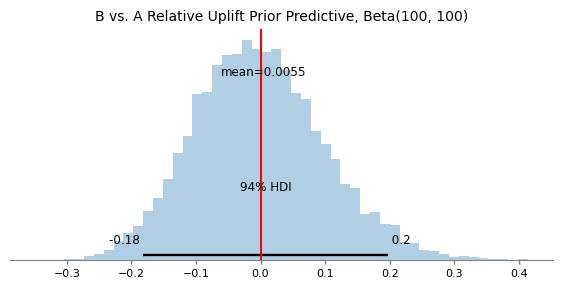

In [33]:
az.plot_posterior(weak_outcome["uplift_B"].values, **plotting_defaults, figsize=(7, 3))

plt.title(f"B vs. A Relative Uplift Prior Predictive, Beta{weak_alpha, weak_beta}", fontsize=10)
plt.axvline(x=0, color="red");

How we choose these priors in practice depends on broader context of the company running the A/B tests. 

- A strong prior can help guard against false discoveries, but may **require more data** to detect winning variants when they exist (and more data = more time required running the test). 
- A weak prior gives **more weight to the observed data**, but could also lead to more false discoveries as a result of early stopping issues.

### PART II: still no data yet, let's check the posterior

In [35]:
with pm.Model() as model:

    # Priors for unknown model parameters
    theta = pm.Beta("theta", 
                    alpha = weak_alpha, 
                    beta  = weak_beta, 
                    shape = 2)
    
    # Likelihood (sampling distribution) of observations
    obs = pm.Binomial("y", 
                      n = trials, 
                      p = theta, 
                      observed = successes,
                      shape = 2) 
    
    # Difference between variants
    relative_uplift = pm.Deterministic("uplift_B", 
                                 theta[1] / theta[0] - 1)

    # Draw samples from the posterior
    trace = pm.sample(draws=10000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 30 seconds.


In [36]:
# Each row of an array is treated as an independent series of draws from the variable, called a chain.
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [37]:
# as an example, for theta we have 4 chains, each with 5000 draws. The last value 2 refers to the theta_A and theta_B. So for theta_A we have 4 chains, each with 5000 draws.
# and same for theta_B.
trace.posterior.theta.shape

(4, 10000, 2)

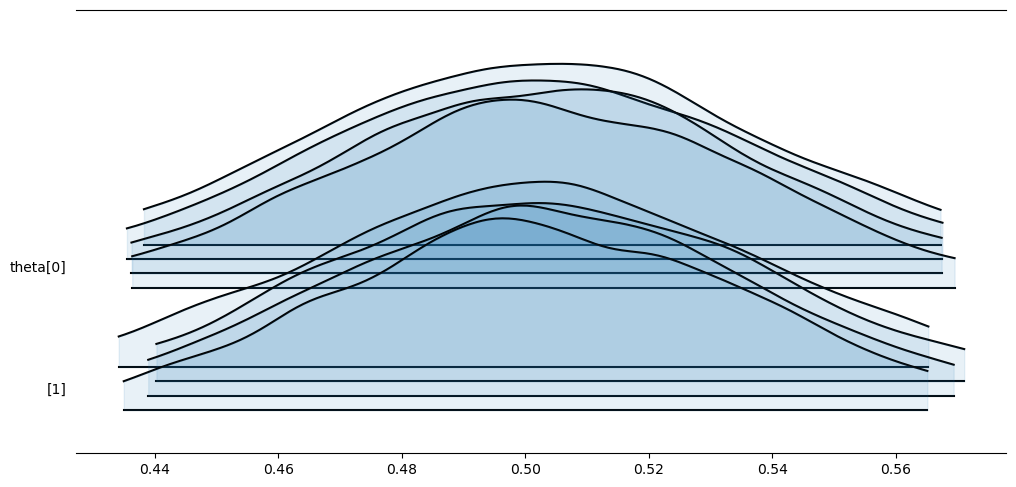

In [39]:
az.plot_forest(trace, var_names=["theta"], combined=False, kind="ridgeplot", ridgeplot_alpha=0.1);

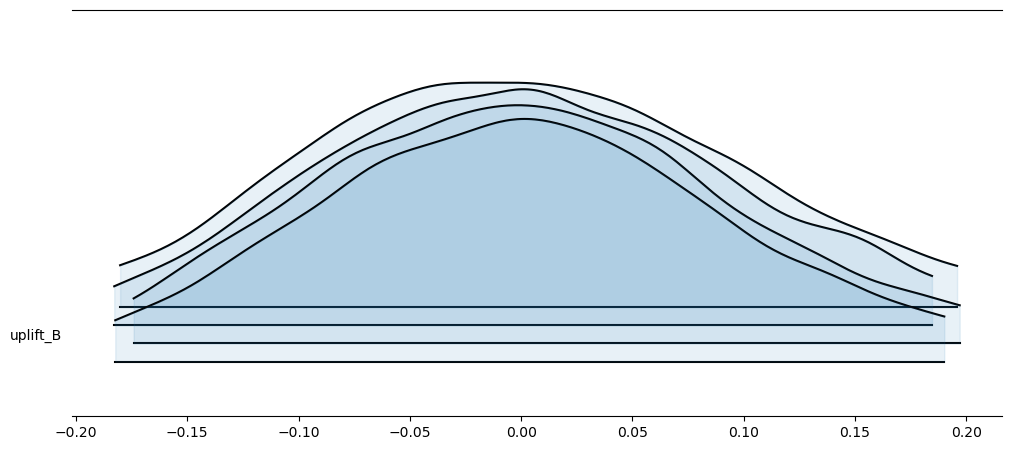

In [42]:
az.plot_forest(trace, var_names=["uplift_B"], combined=False, kind="ridgeplot", ridgeplot_alpha=0.1);

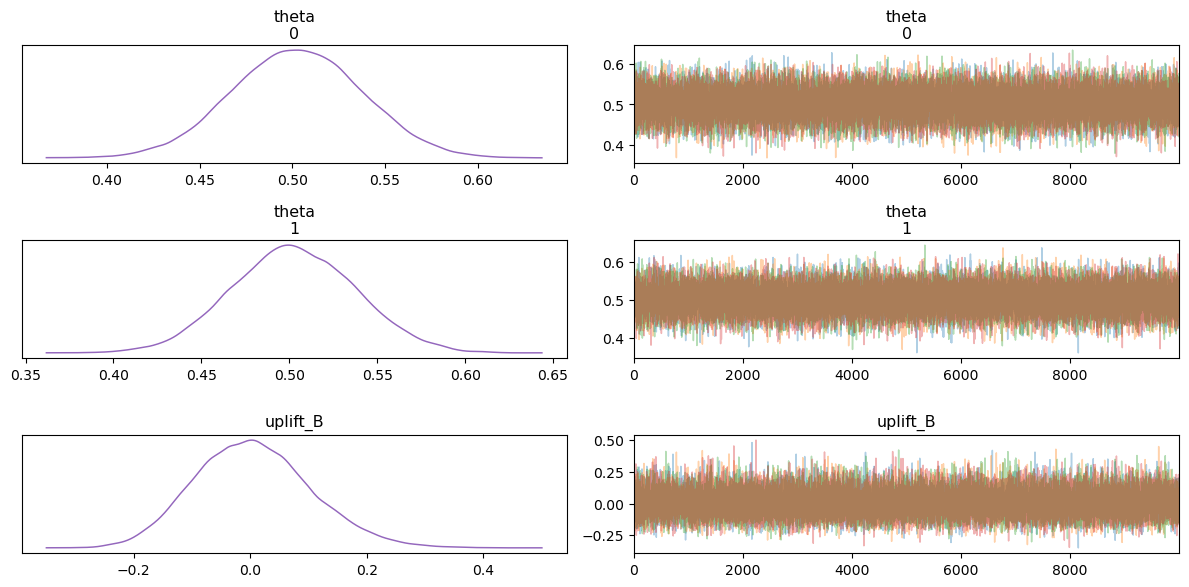

In [46]:
az.plot_trace(trace, compact=False, combined=True)
plt.tight_layout();

these codes and plots become slides and you explain them with the text stored in notes.md. During the hands-on they try with simulated data from bernoulli distribution.

Day02-2 will be only hands-on, where they learn about **value conversion**.
Day02-3-4 will be the same but with their own data.